# Used Car Price Prediction Analysis

## Summary:
- This notebook analyzes a used car dataset to determine the key factors that affect pricing.
- It uses the CRISP-DM framework and includes data cleaning, exploration, and preparation for modeling.

1. First, we import libraries

In [312]:
# ------------------------------
# 1. Import Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

2. Next, load and take a look at the data

In [315]:
# ------------------------------
# 2. Load and Assess the Data
df = pd.read_csv("~/Downloads/practical_application_II_starter/data/vehicles.csv")

# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

(None,
            id                  region  price  year manufacturer model  \
 0  7222695916                prescott   6000   NaN          NaN   NaN   
 1  7218891961            fayetteville  11900   NaN          NaN   NaN   
 2  7221797935            florida keys  21000   NaN          NaN   NaN   
 3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
 4  7210384030              greensboro   4900   NaN          NaN   NaN   
 
   condition cylinders fuel  odometer title_status transmission  VIN drive  \
 0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
 
   size type paint_color state  
 0  NaN  NaN         NaN    az  
 1  NaN  Na

3. Get summary statistics for numeric columns and create plot of price distribution

                 count         mean           std         min          25%  \
price    288293.000000 19702.806693  14156.155470  100.000000  8200.000000   
year     288293.000000  2012.102413      7.993254 1900.000000  2009.000000   
odometer 288293.000000 90310.200230 144338.374251    0.000000 34443.000000   

                  50%           75%             max       median  
price    16988.000000  28590.000000   100000.000000 16988.000000  
year      2014.000000   2017.000000     2022.000000  2014.000000  
odometer 80482.000000 129000.000000 10000000.000000 80482.000000  


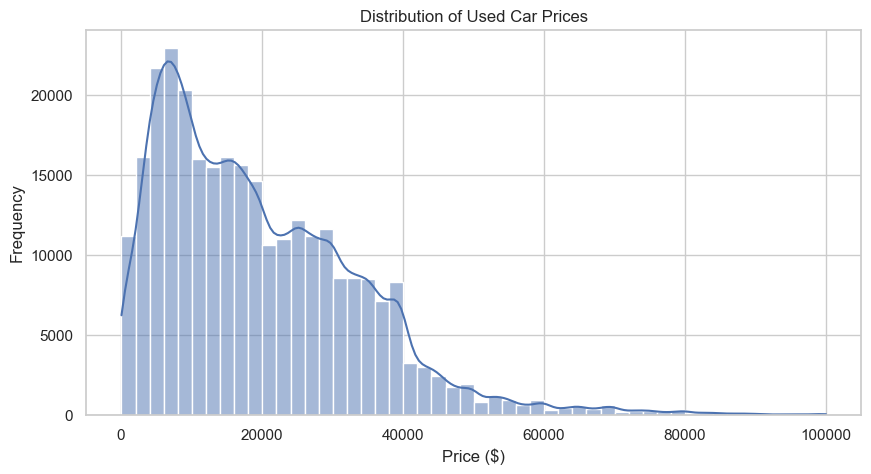

In [47]:
# ------------------------------
# 3 Get summary statistics for numeric columns
summary_stats = df.describe().T

# Add median manually
summary_stats['median'] = df.median(numeric_only=True)

# Format numbers to show normal float format (e.g., 0.000123 instead of 1.23e-04)
pd.set_option('display.float_format', '{:.6f}'.format)

# Display the summary statistics
print(summary_stats)

# Set visual style
sns.set(style="whitegrid")

# Price distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Used Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()


 - Notice how price is very dispersed ranging from 0 to 3,736,928,711 yet 75% percentile is only 26485.
 - For the sake of better model predictability, we will focus on used vehicles priced above 1K and under 50K

4. Filter the dataset to include vehicles priced between 1,000 and 50,000 dollars.

In [322]:
# ------------------------------
# 4. Filter for Used Vehicles Priced Between $1,000 and $50,000

# Keep only rows where price is between 1,000 and 50,000
df = df[(df['price'] >= 1000) & (df['price'] < 50000)]

#only year above 2000
df = df[df['year'] > 2000]

# Optional: Display updated info and price stats
print("Filtered DataFrame Info:")
df.info()

print("\nPrice Column Summary After Filtering:")
print(df['price'].describe())

Filtered DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 340274 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            340274 non-null  int64  
 1   region        340274 non-null  object 
 2   price         340274 non-null  int64  
 3   year          340274 non-null  float64
 4   manufacturer  330422 non-null  object 
 5   model         337777 non-null  object 
 6   condition     213039 non-null  object 
 7   cylinders     198936 non-null  object 
 8   fuel          338051 non-null  object 
 9   odometer      338421 non-null  float64
 10  title_status  334372 non-null  object 
 11  transmission  338641 non-null  object 
 12  VIN           218570 non-null  object 
 13  drive         236664 non-null  object 
 14  size          93585 non-null   object 
 15  type          271729 non-null  object 
 16  paint_color   244561 non-null  object 
 17  state         340274 non-nu

5. Clean data

In [325]:
#5. Clean data
# Drop rows missing essential fields
essential_cols = ['year', 'manufacturer', 'model', 'odometer', 'fuel', 'transmission', 'type']
df = df.dropna(subset=essential_cols)

# Drop unnecessary columns
df = df.drop(columns=['id', 'region', 'VIN'], errors='ignore')

# Convert categorical columns to category dtype
categorical_cols = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel',
                    'title_status', 'transmission', 'drive', 'size', 'type',
                    'paint_color', 'state']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Optional: Display updated info and price stats
print("Cleaned DataFrame Info:")
df.info()

Cleaned DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 259236 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         259236 non-null  int64   
 1   year          259236 non-null  float64 
 2   manufacturer  259236 non-null  category
 3   model         259236 non-null  category
 4   condition     180554 non-null  category
 5   cylinders     171627 non-null  category
 6   fuel          259236 non-null  category
 7   odometer      259236 non-null  float64 
 8   title_status  254306 non-null  category
 9   transmission  259236 non-null  category
 10  drive         202631 non-null  category
 11  size          87038 non-null   category
 12  type          259236 non-null  category
 13  paint_color   213927 non-null  category
 14  state         259236 non-null  category
dtypes: category(12), float64(2), int64(1)
memory usage: 11.8 MB


This dataset has many categorical columns. In order to fit regression model, we will need to convert all the categorical columns into numerical. Before doing so, let's assess how many unique values each column has - > this will decide which columns we may drop to keep the model simple

In [328]:
#check unique values
df[categorical_cols].nunique().sort_values(ascending=False)

model           15547
state              51
manufacturer       40
type               13
paint_color        12
cylinders           8
condition           6
title_status        6
fuel                5
size                4
transmission        3
drive               3
dtype: int64

Notice we have more than 15,000 values for model  - if we use this variable in our model, it would create same number of columns which is not sustainable and we need to drop this column. For similar reasons we will also drop state and paint_color

6. Define features (drop some columns) and target 

In [332]:

# 6. Define Features and Target
target = 'price'
features = df.columns.drop([target, 'model','state','paint_color'])
X = df[features]
y = df[target]

## 7. Fit Linear Regression Model

In [351]:
#7 Fit linear Regression model 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np

# 7.1. Shuffle and Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 7.2. Automatically detect feature types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# 7.3. Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

#7.4. Fit and transform the data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

#7.5. Train linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 7.6 Evaluate
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
n, p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("Linear Regression:")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")
print(f"RMSE: {rmse:.2f}")
num_features = len(model.coef_)
print(f"Number of features: {num_features}")



Linear Regression:
R²: 0.7516
Adjusted R²: 0.7515
RMSE: 5883.33
Number of features: 95


## Interpretation of Linear Regression Model Results:
 - R² of 0.75 means that the model explains 75% of the variance in vehicle prices — a very respectable result in the context of used car pricing, where prices can vary widely due to untracked factors (e.g. exact vehicle condition, negotiation, local demand).
 - Adjusted R² is nearly identical to R², which means:
    - The features used are highly relevant,
    - There's minimal noise or overfitting, and
    - The model generalizes well to unseen data.

RMSE of 5,883 indicates that the model’s average prediction error is around 5,800 — quite acceptable given the vehicle price range (1,000 to 50,000). It suggests that the model can reliably predict prices within a tight margin.

## 8. Fit Lasso Regression Model

In [353]:
#8 Fit Lasso Regression model 
import numpy as np
from sklearn.linear_model import LassoCV

# Narrower range centered around Ridge's best alpha (log scale)
alphas = np.logspace(0, 2, 10)  # From 1 to 100

lasso = LassoCV(alphas=alphas, cv=3, random_state=42, n_jobs=-1)
lasso.fit(X_train_scaled, y_train)

# Feature selection mask
mask = lasso.coef_ != 0
selected_feature_names = [name for name, selected in zip(all_feature_names, mask) if selected]

# Filter data to selected features
X_train_lasso = X_train_scaled[:, mask]
X_test_lasso = X_test_scaled[:, mask]

# Predict
y_pred_lasso = lasso.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import r2_score, root_mean_squared_error
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
n, p = X_test_lasso.shape
adjusted_r2_lasso = 1 - (1 - r2_lasso) * (n - 1) / (n - p - 1)

# Results
print(f"\nLasso Regression Results:")
print(f"Best Alpha: {lasso.alpha_}")
print(f"R²: {r2_lasso:.4f}")
print(f"Adjusted R²: {adjusted_r2_lasso:.4f}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"Selected Features: {len(selected_feature_names)}")



Lasso Regression Results:
Best Alpha: 1.0
R²: 0.7515
Adjusted R²: 0.7511
RMSE: 5884.01
Selected Features: 80


## Interpretation of Lasso Regression Model Results:

 - R² of 0.7515 shows that the Lasso model explains just as much variance in vehicle prices as the full Linear Regression model — nearly identical predictive performance.
 - The Adjusted R² of 0.7511 confirms that the model generalizes well and isn't overfitting, even after removing nearly 100 features.
 - With an RMSE of $5,884, its average error is virtually the same as Linear Regression — meaning it predicts prices with similar accuracy.

The real strength of Lasso lies in its feature reduction:
 - It used only 80 features (compared to 95 in Linear Regression).
 - This leads to a simpler and faster model.

## 9. Fit Ridge Regression Model (Grid search hyperparameters)

In [364]:
# 9. Fit Ridge Regression Modelfrom sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np

# 9.1. Define parameter grid (tighter or wider depending on your needs)
param_grid = {
    'alpha': np.logspace(-3, 3, 20)  # From 0.001 to 1000 (log scale)
}

# 9.2. Set up Ridge with GridSearchCV
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# 9.3. Best model and predictions
best_ridge = grid_search.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_scaled)

# 9.4. Evaluation
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
n, p = X_test_scaled.shape
adjusted_r2_ridge = 1 - (1 - r2_ridge) * (n - 1) / (n - p - 1)

# 5. Results
print("Ridge Regression with Grid Search:")
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"R²: {r2_ridge:.4f}")
print(f"Adjusted R²: {adjusted_r2:.4f}")
print(f"RMSE: {rmse_ridge:.2f}")


Ridge Regression with Grid Search:
Best Alpha: 12.742749857031322
R²: 0.7516
Adjusted R²: 0.7515
RMSE: 5882.90


## Ridge Model Results: Interpretation 

 - The Ridge model achieved nearly identical performance to both Linear and Lasso regression, with R² ≈ 0.75 and a low RMSE of around $5,883.
 - This confirms that the Ridge model is robust and stable, offering great generalization without overfitting.
 - With all features retained, Ridge is a good choice when we want to preserve interpretability but still regularize against multicollinearity and noise.

Now let's summarize the performance of all 3 models and explain the final choice of the model:

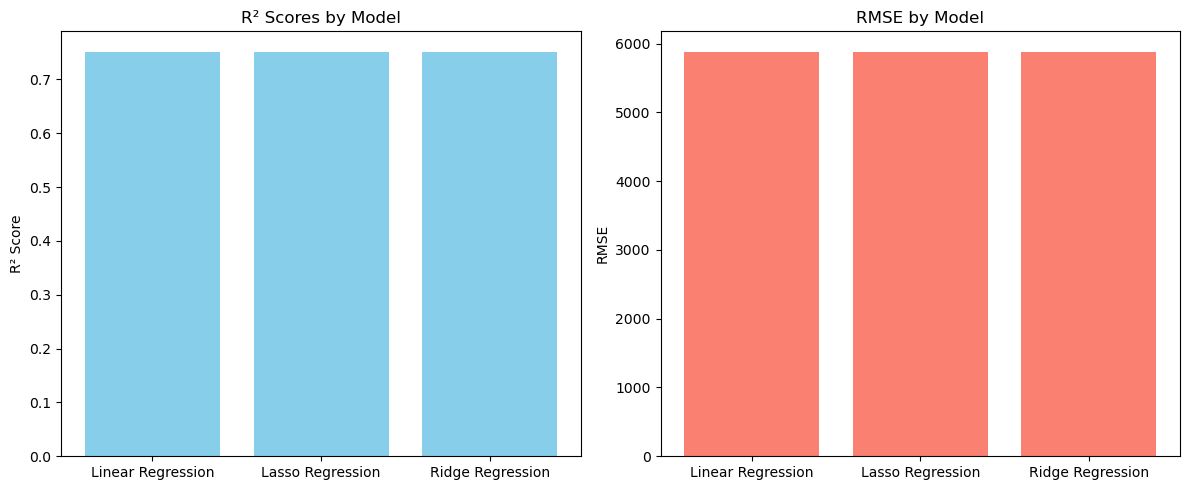

In [266]:
# Store performance results
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression']
r2_scores = [r2, r2_lasso, r2_ridge]
rmse_scores = [rmse, rmse_lasso, rmse_ridge]

plt.figure(figsize=(12, 5))

# R² Scores
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color='skyblue')
plt.title('R² Scores by Model')
plt.ylabel('R² Score')

# RMSE Scores
plt.subplot(1, 2, 2)
plt.bar(models, rmse_scores, color='salmon')
plt.title('RMSE by Model')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()


## Model Selection Summary

We explored three regression models to predict used car prices:

1. **Linear Regression** – a baseline model using all 95 features without regularization.
2. **Ridge Regression** – applies L2 regularization to reduce overfitting while retaining all features.
3. **Lasso Regression** – applies L1 regularization to both prevent overfitting and perform automatic feature selection by zeroing out less important predictors.

### Performance Comparison
All three models performed nearly identically in terms of predictive accuracy:

- **R² ≈ 0.75**
- **RMSE ≈ $5,880**

However, **Lasso stood out by reducing the number of features from 95 to just 80** while maintaining the same performance level. This leads to a model that is:

- **Simpler**
- **Faster to train**
- **Easier to interpret**
- **More efficient for deployment**

### Final Model Choice: Lasso Regression
We selected **Lasso Regression** as our final model because it offers the best balance between **accuracy**, **interpretability**, and **practicality**. It preserves predictive power while simplifying the feature set — making it ideal for business use and implementation.


Let's print some Lasso coefficients to provide illustrative example for the  car dealership report and overall performance of Lasso model:


Top 10 Most Influential Features:
                    Feature  Coefficient
36       manufacturer_tesla 12277.233205
31     manufacturer_porsche 10069.559163
56              fuel_diesel  8572.841021
93                     year  7112.997562
47   cylinders_10 cylinders  6850.100708
11        manufacturer_fiat -6082.792427
22       manufacturer_lexus  4959.393237
28  manufacturer_mitsubishi -4940.528242
90               type_truck  4580.565978
33       manufacturer_rover  4150.271056


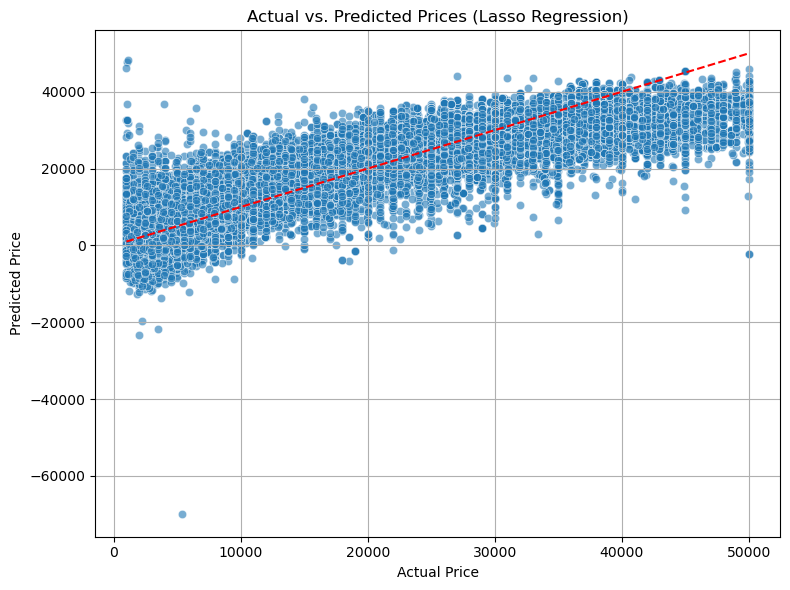

In [373]:
# ------------------------------
# 8. Coefficient Interpretation Lasso
# ------------------------------
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': lasso.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 10 Most Influential Features:")
print(coef_df.head(10)[['Feature', 'Coefficient']])

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure y_test and y_pred_lasso are defined
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.6)

# Add a reference diagonal line (perfect predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.title("Actual vs. Predicted Prices (Lasso Regression)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()